In [39]:
import h5py
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import Dense, Dropout,LSTM,Conv1D,Flatten,MaxPooling1D,UpSampling1D
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.models import Model
from keras import layers
from keras.utils import plot_model
import scipy.stats as stats
from data_augmentation.augmentation import *
from data_augmentation.helper import *
import seaborn as sns

from joblib import Parallel, delayed
from sklearn.cluster import dbscan
import joblib
from tqdm.notebook import tqdm
import keras_tuner

import umap
import umap.plot

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier

## H5 Extraction functions

In [2]:
N_ELECTRODES = 32
CUT_OFF = 120
STEP_CUT_OFF = 25
CYCLE_PER_SEC = 30000

raw_stream = "Data/Recording_0/AnalogStream/Stream_1/ChannelData"
electrode_tpl = "Data/Recording_0/SegmentStream/Stream_0/SegmentData"


def find_sublist(sub, bigger):
    if not bigger:
        return -1
    if not sub:
        return 0
    first, rest = sub[0], sub[1:]
    pos = 0
    try:
        while True:
            pos = bigger.index(first, pos) + 1
            if not rest or bigger[pos:pos+len(rest)] == rest:
                return pos
    except ValueError:
        return -1 

def get_raw_electrode_data(path: str, electrode_number_start: int, electrode_number_stop: int,label: int) -> np.ndarray:
    f = h5py.File(path, mode='r')
    X = []
    Y = []

    for index in range(electrode_number_start, electrode_number_stop):
        print(f'\nNum electrode : {index}')
        spike_windows = np.array(f[f'{electrode_tpl}_{index}'][()]).T
        dataRaw = f[f'{raw_stream}'][index]
        range_cut_off = []

        K = len(spike_windows)
        for indx,spke in enumerate(spike_windows):
            tmp = find_sublist(spke.tolist(), dataRaw.tolist())
            if(tmp != -1):
                if(tmp - (CUT_OFF/2) >= 0):
                    cut = CUT_OFF/2
                    range_cut_off = dataRaw[tmp-cut:tmp+cut]
                else:
                    range_cut_off = dataRaw[tmp:tmp+CUT_OFF]

                X.append(range_cut_off)
                Y.append(label)    
            print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))

    return X, Y

def get_raw_data(path: str) -> np.ndarray:
    f = h5py.File(path, mode='r')
    X = []
    Y = []

    for index in range(10,13):
        print(f'\nNum electrode : {index}')
        spike_windows = f[f'SpikeWindow-0.{index}'][()]
        dataRaw = f[f'Raw-0.{index}'][0:len(f[f'Raw-0.{index}']):1, 1]
        sp = []

        K = len(spike_windows)
        for indx,spke in enumerate(spike_windows):
            tmp = find_sublist(spke.tolist(), dataRaw.tolist())
            if(tmp != -1):
                sp.append(tmp + 30)
            print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))
        
        for i in range(0,len(dataRaw)-CUT_OFF,CUT_OFF):
            range_cut_off = dataRaw[i:i+CUT_OFF]
            if(any(x in sp for x in range(i,i+CUT_OFF))):
                Y.append(1)
            else:
                Y.append(0)
            X.append(range_cut_off)

    return X, Y

def get_noise_data(path: str,shape:int,arr: np.ndarray) -> np.ndarray:
    f = h5py.File(path, mode='r')
    X = []
    Y = []

    for index in arr:
        print(f'\nNum electrode : {index}')
        spike_windows = f[f'SpikeWindow-0.{index}'][()]
        print(len(spike_windows))
        dataRaw = f[f'Raw-0.{index}'][0:len(f[f'Raw-0.{index}']):1, 1]
        sp = []

        K = len(spike_windows)
        for indx,spke in enumerate(spike_windows):
            tmp = find_sublist(spke.tolist(), dataRaw.tolist())
            if(tmp != -1):
                sp.append(tmp + 30)
            print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))
        
        for i in range(0,len(dataRaw)-CUT_OFF,CUT_OFF):
            if(len(X) == shape):
                return X
            range_cut_off = dataRaw[i:i+CUT_OFF]
            if(not any(x in sp for x in range(i,i+CUT_OFF))):
                X.append(range_cut_off)



def get_spike_data(path: str, arr: np.ndarray) -> np.ndarray:
    f = h5py.File(path, mode='r')
    sp = []

    for index in arr:
        print(f'\nNum electrode : {index}')
        spike_windows = f[f'SpikeWindow-0.{index}'][()]

        K = len(spike_windows)
        print(K)
        for indx,spke in enumerate(spike_windows):
            sp.append(spke[0:CUT_OFF])
            if(K != 1):
                print(end="\r|%-80s|" % ("="*int(80*indx/(K-1))))
    return sp

                
def get_number_spike_raw_data(path: str) -> np.ndarray:
    f = h5py.File(path, mode='r')
    event = 0
    for n in f.keys():
        if("SpikeTimestamp-0" in n):
            event += f[n].shape[0]
    return event
    


In [3]:
x = pd.read_csv('x_raw_0_120.csv', sep=',', header=None)
y = pd.read_csv('y_raw_0_120.csv', sep=',', header=None)

In [5]:
print(f'Spike predicted : {np.count_nonzero(y == 1)}')
print(f'Noise predicted : {np.count_nonzero(y == 0)}')

Spike predicted : 213
Noise predicted : 523503


In [15]:
cpt_spk = 0
cpt_nse = 0
y_np = y.to_numpy()
x_small = []
y_small = []
for index,row in x.iterrows():
    if(y_np[index] == 1 and cpt_spk < 200):
        x_small.append(row)
        cpt_spk += 1
        y_small.append(1)

    if(y_np[index] == 0 and cpt_nse < 200):
        x_small.append(row)
        cpt_nse += 1
        y_small.append(0)


    if(cpt_spk == 200 and cpt_nse == 200):
        break


In [19]:
pd_x = pd.DataFrame (x_small)
pd_y = pd.DataFrame (y_small)

# UMAP

In [22]:
N_NEIGHBORS = [5, 15, 25, 50, 100, 200]
MIN_DISTS = [0.1, 0.25, 0.5, 0.8, 0.99]

def build_all_mappers(data):
    mappers = []
    for n in tqdm(N_NEIGHBORS):
        for d in tqdm(MIN_DISTS, leave=False):
            path = f'./model/mapper-{n}-{d}'
            try:
                mapper = umap.UMAP(n_neighbors=n, min_dist=d).fit(data)
                mappers.append(mapper)
                joblib.dump(mapper, path)
            except Exception as e: 
                print(e)
    return mappers

In [23]:
print("Build mappers form data")

mappers = build_all_mappers(pd_x)

Build mappers form data


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

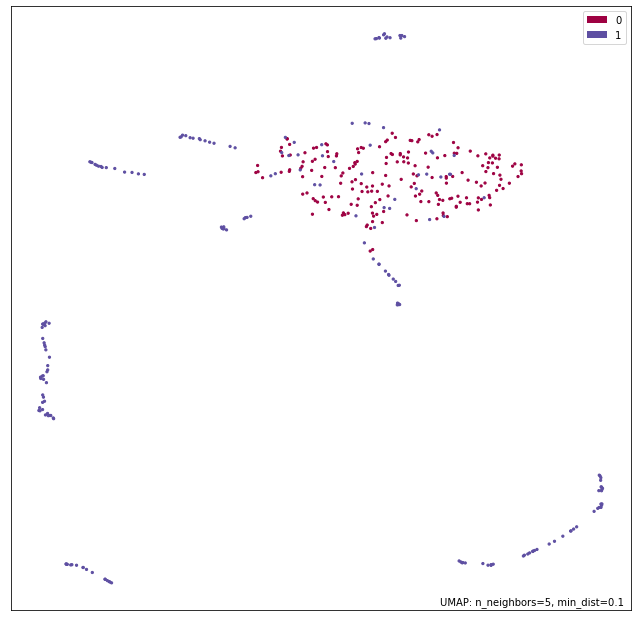

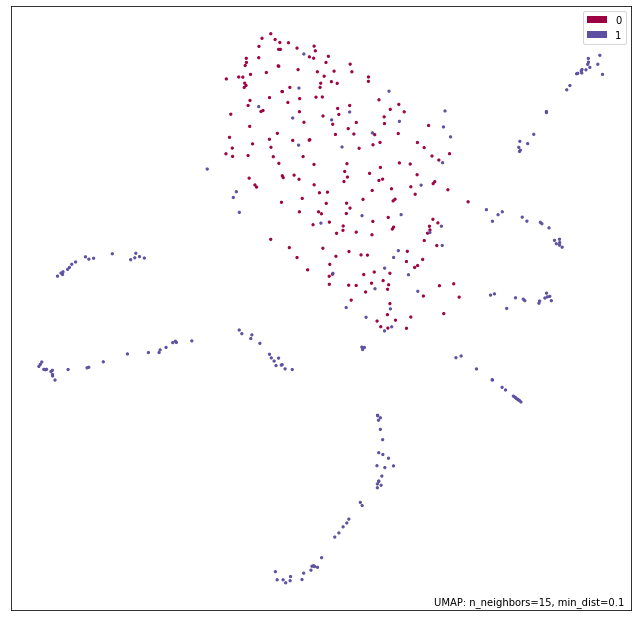

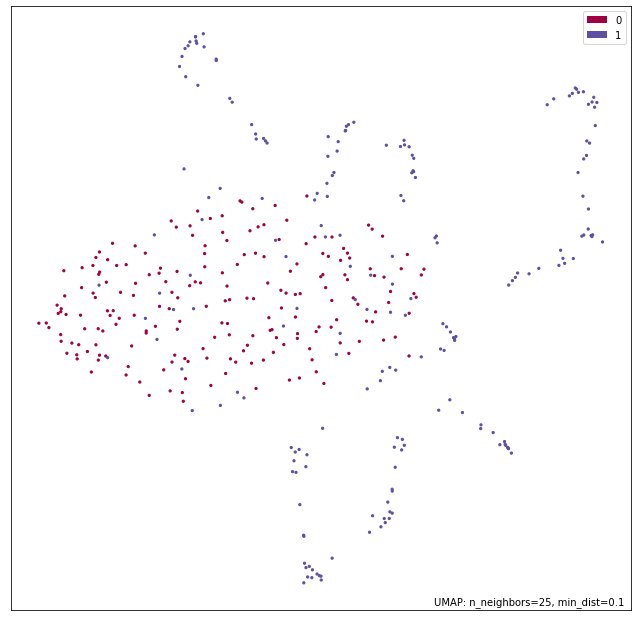

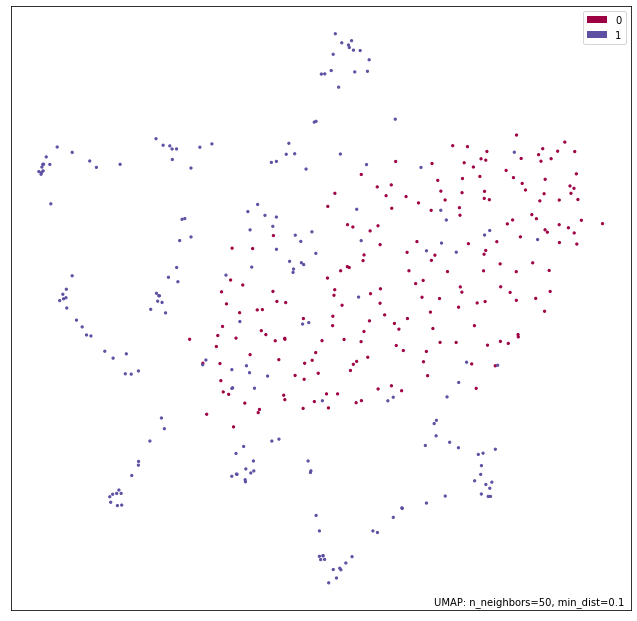

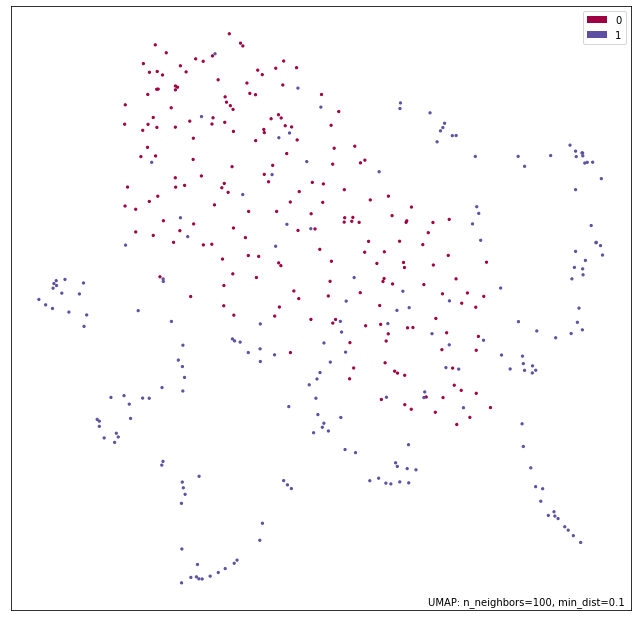

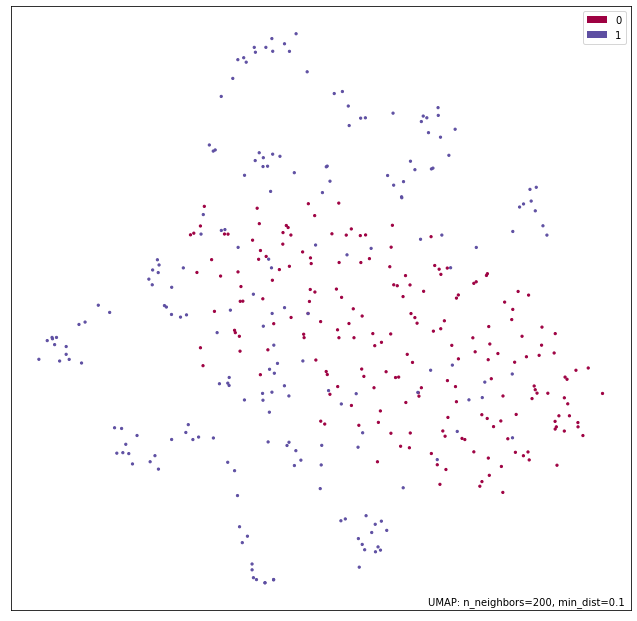

In [24]:
for mapper in mappers[::5]:
    umap.plot.points(mapper,labels=pd_y.to_numpy().flatten())

## Data augmentation

In [15]:
# scal = scaling(all_spikes_normalized)
# perm_scal = permutation(scal)
# magn = magnitude_warp(all_spikes_normalized)
# perm_magn = permutation(magn)
# time = time_warp(all_spikes_normalized)
# perm_time = permutation(time)
# warp = window_warp(all_spikes_normalized,.9)
# perm_warp = permutation(warp)

# perm_all_spikes_augmented = permutation(np.concatenate((all_spikes_normalized,magn,time,warp,scal,perm_scal,perm_magn,perm_time,perm_warp)))

# all_spikes_augmented = np.concatenate((all_spikes_normalized,magn,time,warp,scal,perm_scal,perm_magn,perm_time,perm_warp,perm_all_spikes_augmented))
# print(all_spikes_augmented.shape)

# all_spikes_augmented = all_spikes_augmented.reshape(all_spikes_augmented.shape[0],all_spikes_augmented.shape[1])
# all_spikes_normalized = all_spikes_normalized.reshape(all_spikes_normalized.shape[0],all_spikes_normalized.shape[1])

# print(all_spikes_augmented.shape)
# all_spikes_augmented = all_spikes_normalized


In [17]:
# spike_noise_ratio = all_spikes_augmented.shape[0] / all_noises.shape[0]
# print(f"Got a {spike_noise_ratio:.1%} spike to noise ratio")

## Prepare dataset

In [25]:
from sklearn import model_selection as ms

#define train and test split

x_train, x_test, y_train, y_test = ms.train_test_split(pd_x, pd_y, 
                                     test_size=0.20, random_state=1)

# x_train_spike, x_test_spike, y_train_spike, y_test_spike = ms.train_test_split(df_spike, y_spike, 
#                                      test_size=0.20, random_state=1)

print("---------------- Dataset ------------------")
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# print("------------- Dataset Spike ---------------")
# print(x_train_spike.shape, x_test_spike.shape, y_train_spike.shape, y_test_spike.shape)

---------------- Dataset ------------------
(320, 120) (80, 120) (320, 1) (80, 1)


## Define model

In [26]:
if os.path.exists("denoising_Dense_1.h5"):
    autoencoder = tf.keras.models.load_model('denoising_Dense_1.h5')

In [27]:
output_layer = (autoencoder.layers[-11].output)

encoder = Model(autoencoder.input, output_layer)

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120)]             0         
                                                                 
 dense_7 (Dense)             (None, 240)               29040     
                                                                 
 batch_normalization_6 (Batc  (None, 240)              960       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 240)               0         
                                                                 
 dense_8 (Dense)             (None, 120)               28920     
                                                                 
 batch_normalization_7 (Batc  (None, 120)              480       
 hNormalization)                                             

In [28]:
X_train_encode = encoder.predict(x_train)
X_test_encode = encoder.predict(x_test)

3/3 [==============================] - 0s 2ms/step


In [29]:
print("Build mappers form data")

mappers = build_all_mappers(X_train_encode)

Build mappers form data


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

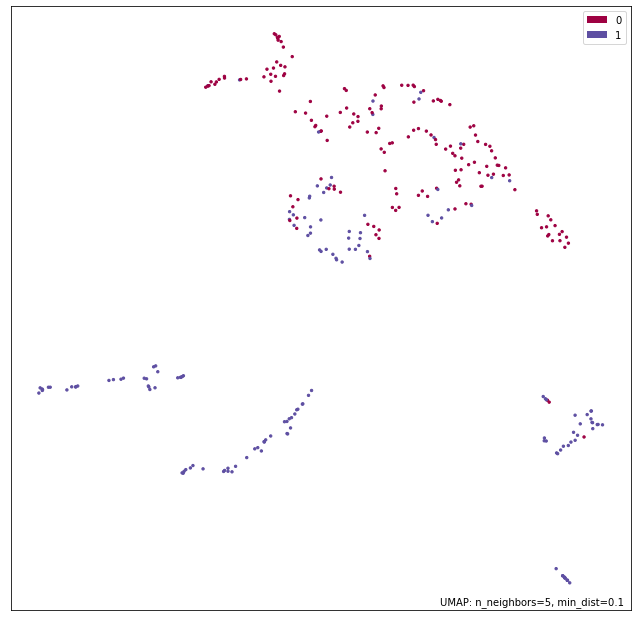

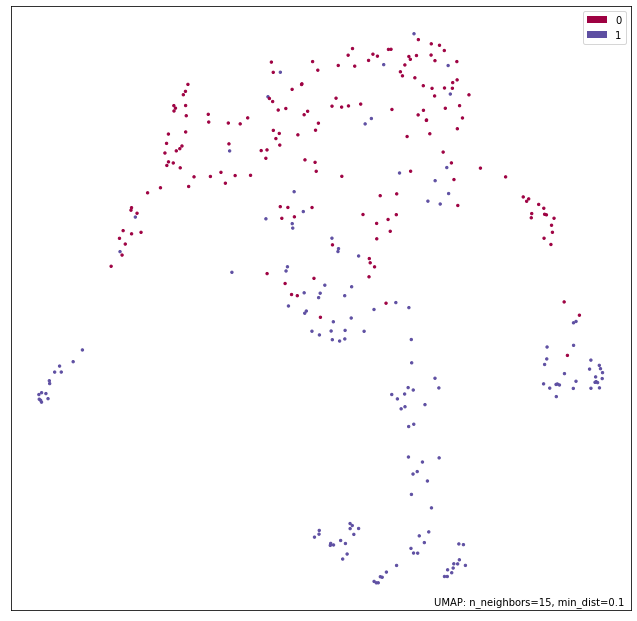

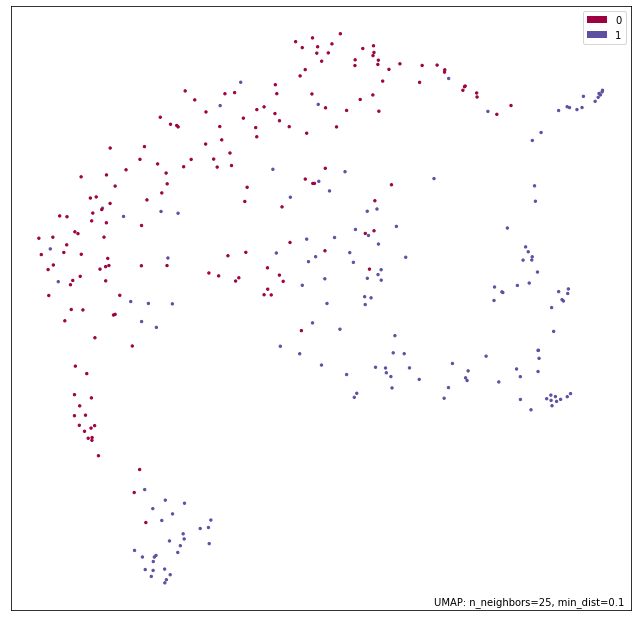

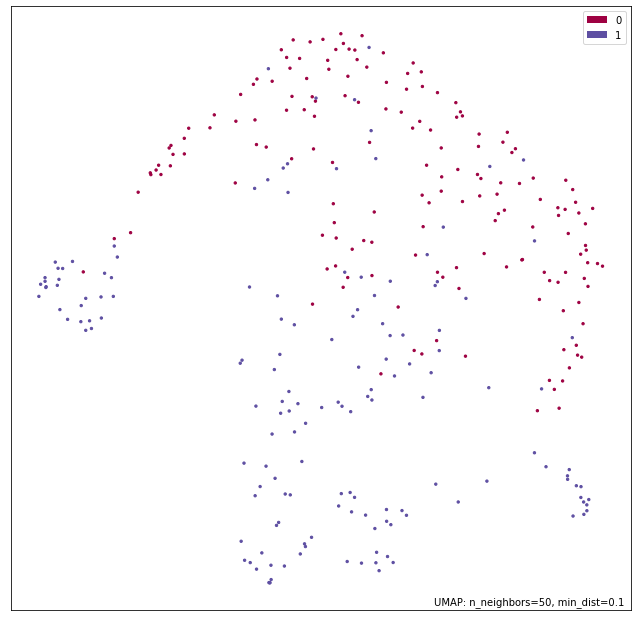

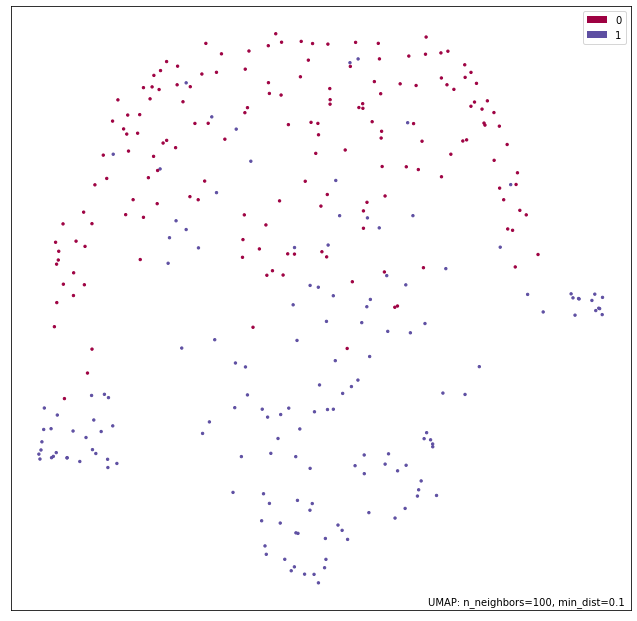

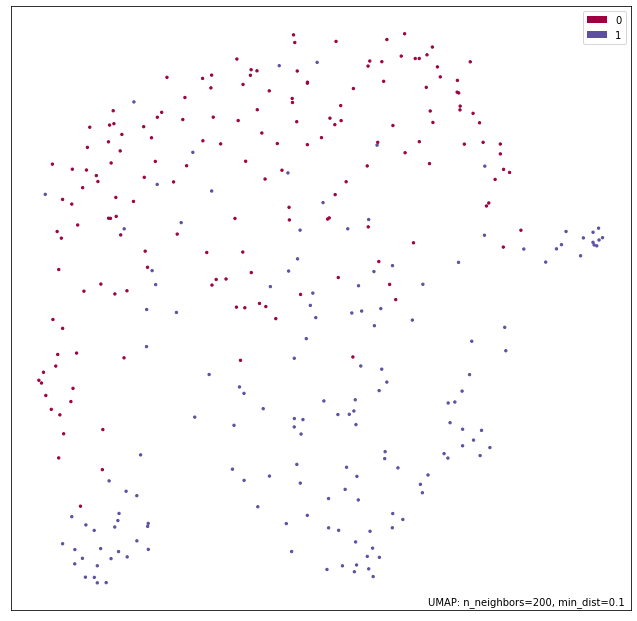

In [30]:
for mapper in mappers[::5]:
    umap.plot.points(mapper,labels=y_train.to_numpy().flatten())

In [34]:
def build_model_cnn(hp):
    n_inputs = X_train_encode.shape[1]

    model = keras.Sequential()
    model.add(Input(shape=(n_inputs,1)))
    model.add(Conv1D(filters = hp.Choice('cnn1', [32,64,128,256]), kernel_size = hp.Choice('kernel1', [3,5,7,9]), activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters = hp.Choice('cnn2', [32,64,128,256]), kernel_size = hp.Choice('kernel2', [3,5,7,9]), activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters = hp.Choice('cnn3', [32,64,128,256]), kernel_size = hp.Choice('kernel3', [3,5,7,9]), activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model with Adam optimizer
    model.compile(loss='binary_crossentropy',
                metrics=['accuracy'],
                optimizer='Adam')
    print(model.summary())
    return model

In [37]:
train = True
if train:
    tuner = keras_tuner.RandomSearch(
        build_model_cnn,
        objective='val_loss',
        max_trials=5,
        project_name="Classifier_CNN")
    tuner.search(X_train_encode, y_train, epochs=10, callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001),
        ], validation_split=0.15)
    bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
    # build the best model and train it
    print("[INFO] training the best model...")
    model = tuner.hypermodel.build(bestHP)
    H = model.fit(x=X_train_encode, y=y_train,
        validation_split=0.15,
        epochs=50, callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, mode="min"),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001),
        ], verbose=1)
else:
    if os.path.exists('CNN_Classifier.h5'):
        model = tf.keras.models.load_model('CNN_Classifier.h5')

INFO:tensorflow:Reloading Oracle from existing project .\Classifier_CNN\oracle.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 32)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            3104      
                                      

In [45]:
X_encode = encoder.predict(x)

16367/16367 [==============================] - 16s 961us/step


[INFO] evaluating network...
16367/16367 [==============================] - 36s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    523503
         1.0       0.00      0.89      0.01       213

    accuracy                           0.88    523716
   macro avg       0.50      0.88      0.47    523716
weighted avg       1.00      0.88      0.93    523716



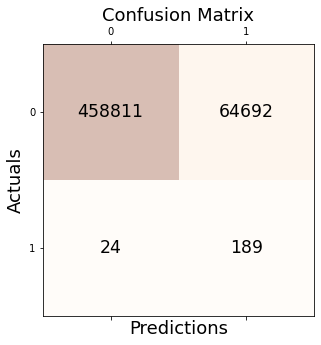

In [47]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=X_encode, batch_size=32).round()
print(classification_report(y,predictions))
# generate the training loss/accuracy plot

conf_matrix = confusion_matrix(y_true=y, y_pred=predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
   
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

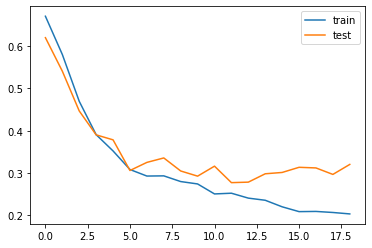

In [48]:
plt.plot(H.history['loss'], label='train')
plt.plot(H.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
print(f'Custom CNN classifier & {accuracy_score(y, predictions).round(4)} & {recall_score(y, predictions).round(4)} & {precision_score(y, predictions).round(4)} & {f1_score(y, predictions).round(4)}')

Custom CNN classifier & 0.8764 & 0.8873 & 0.0029 & 0.0058


C:\Users\ti-xa\AppData\Local\Temp\ipykernel_6404\3914498007.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


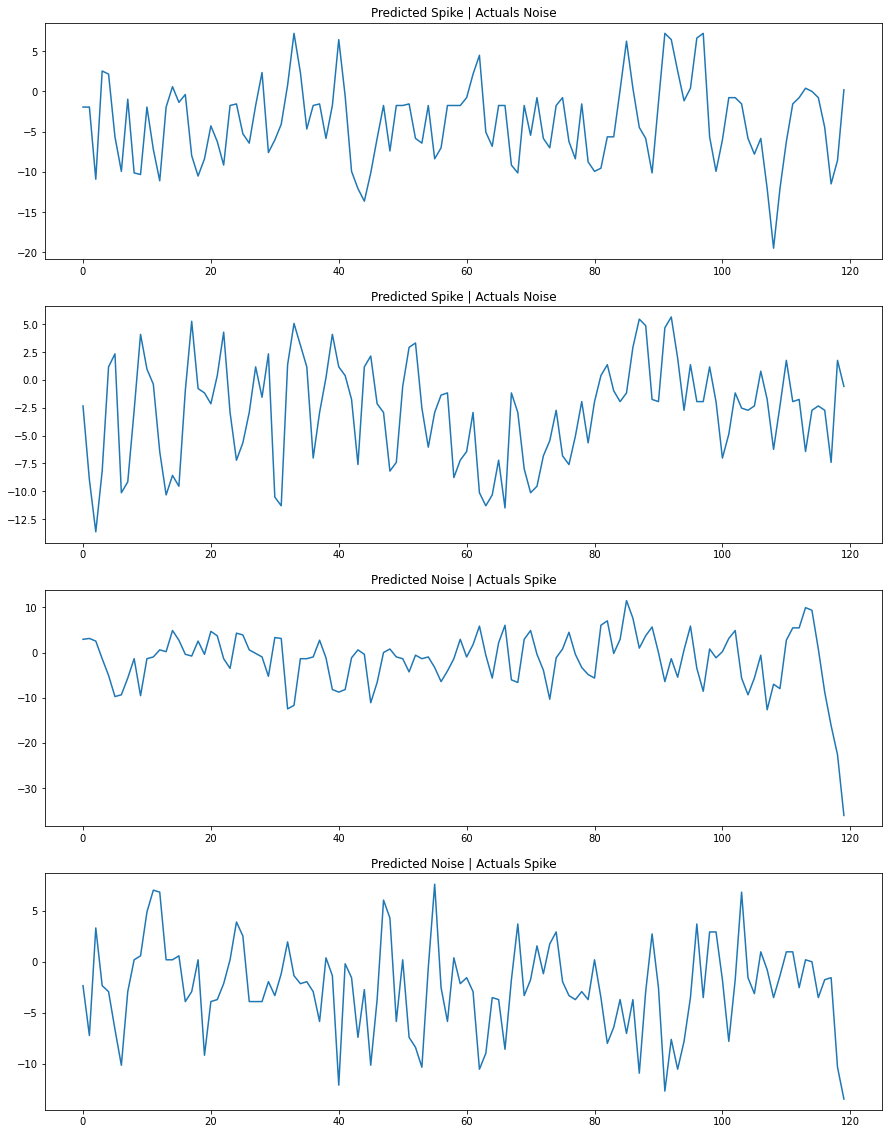

In [55]:
item = 0
tmp = 0
idx = 0

idx_m = 0
idx_p = 0
y_n = y.to_numpy()
fig, axs = plt.subplots(4)
for index,row in x.iterrows():
    fig.set_size_inches(15, 20)
    if(idx == 4):
        break
    if(predictions[item] == 0 and y_n[item] == 1 and idx_m < 2):
        axs[idx].plot(row)
        axs[idx].set_title("Predicted Noise | Actuals Spike")
        idx += 1
        idx_m+=1
    if(predictions[item] == 1 and y_n[item] == 0  and idx_p < 2):
        axs[idx].plot(row)
        axs[idx].set_title("Predicted Spike | Actuals Noise")
        idx += 1
        idx_p+=1

    item += 1
fig.show()

C:\Users\ti-xa\AppData\Local\Temp\ipykernel_6404\1774655490.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


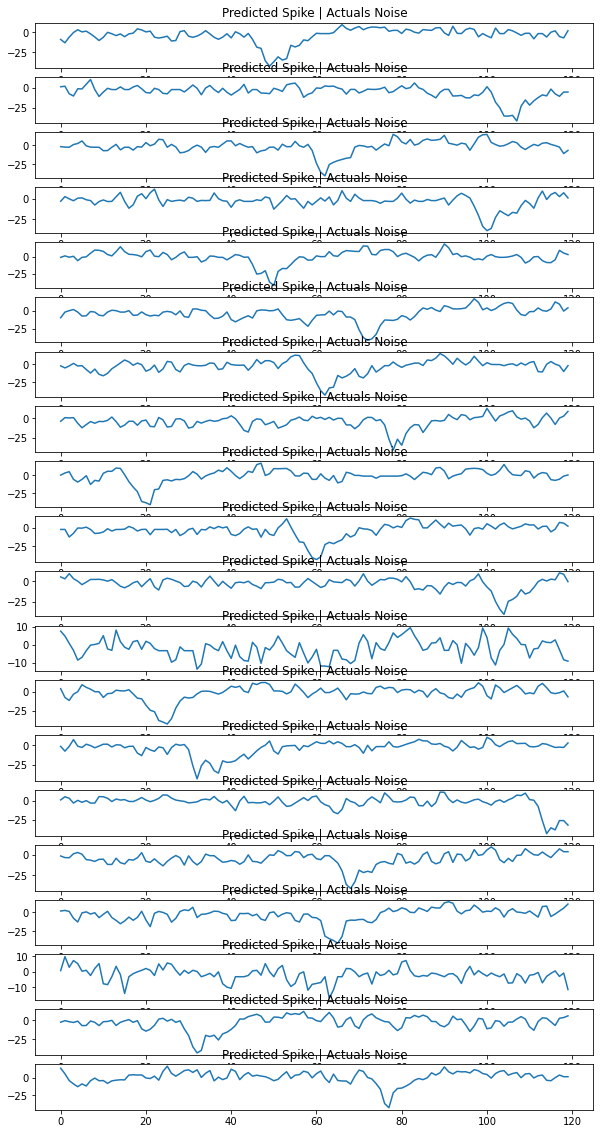

In [59]:
item = 0
tmp = 0
idx = 0

idx_m = 0
idx_p = 0
y_n = y.to_numpy()
fig, axs = plt.subplots(4)
for index,row in x.iterrows():
    fig.set_size_inches(15, 20)
    if(idx == 4):
        break
    if(predictions[item] == 0 and y_n[item] == 1 and idx_m < 2):
        axs[idx].plot(row)
        axs[idx].set_title("Predicted Noise | Actuals Spike")
        idx += 1
        idx_m+=1
    if(predictions[item] == 1 and y_n[item] == 0  and idx_p < 2):
        axs[idx].plot(row)
        axs[idx].set_title("Predicted Spike | Actuals Noise")
        idx += 1
        idx_p+=1

    item += 1
fig.show()